In [2]:
# %%
"""
Jupyter-friendly FiGR-like pipeline (cluster-aware)
- Prefers raw counts for RNA and ATAC
- If RNA & ATAC share no cells, aggregates by Cluster_Idents_New2
- Automatically detects peak-level or gene-level ATAC features
- Uses DoRothEA from local dorothea_hs.rda
- Runs either peak-gene+DORC pipeline or TF-gene regulation analysis
"""

import os
from pathlib import Path
import math
import logging
import numpy as np
import pandas as pd
import scanpy as sc
from tqdm.auto import tqdm
from scipy.stats import spearmanr
from statsmodels.stats.multitest import multipletests
import joblib
import pyreadr
import requests

# ---------- USER CONFIG ----------
h5ad_path = "/mnt/home3/miska/nm667/scratch/inProgress/dev/data/Kidney_SC/GSE211785_Susztak_KPMP_SC_SN_ATAC_merged_PostSCVI_final.h5ad"
outdir = Path(
    "/mnt/home3/miska/nm667/scratch/inProgress/dev/figr_cluster_pipeline")
Path(outdir).mkdir(parents=True, exist_ok=True)
dorothea_rda = "/mnt/home3/miska/nm667/scratch/inProgress/dev/scripts/dorothea_hs.rda"

genes_of_interest = [
  "AOC1", "DPEP1", "CYFIP2", "TM7SF3", "SLC9A3", "ACAT1", "HOXA9", "LGALS2",
  "CUBN", "SLC2A9", "EFHD1", "IL1RL1", "ALDH8A1", "BICC1", "PEPD", "SLC17A3",
  "ARMC7", "PAX8", "ALDOB", "ENPEP", "OCIAD2", "CRB2", "SLC5A10", "KCNJ15",
  "BDH2", "AMN", "ACSF2", "SOST", "UMOD", "SHMT1", "SHMT1", "TCN2", "BCAM",
  "MME", "AC092653.5", "RGL3", "TDGF1", "ACY1"
]
peak_gene_window = 100000
n_permutations = 200
n_jobs = 4
min_dorc_peaks = 3

# ---------- Logging ----------
logging.basicConfig(level=logging.INFO,
                    format="%(asctime)s %(levelname)s: %(message)s")

# ---------- Helper functions ----------


def get_matrix_from_adata(adata_obj, prefer_raw=True, prefer_layer="counts"):
    """Return DataFrame (cells x features) and source label used."""
    if prefer_raw and hasattr(adata_obj, "raw") and adata_obj.raw is not None:
        mat = adata_obj.raw.X
        cols = adata_obj.raw.var_names
        src = "raw"
    elif prefer_layer in adata_obj.layers:
        mat = adata_obj.layers[prefer_layer]
        cols = adata_obj.var_names
        src = f"layers['{prefer_layer}']"
    else:
        mat = adata_obj.X
        cols = adata_obj.var_names
        src = "X"
    if hasattr(mat, "toarray"):
        mat = mat.toarray()
    df = pd.DataFrame(mat, index=adata_obj.obs_names.astype(
        str), columns=cols.astype(str))
    return df, src


def parse_peak_index_to_df(var_index):
    rows = []
    for idx in var_index:
        if not isinstance(idx, str):
            continue
        if ":" in idx and "-" in idx:
            try:
                ch, rest = idx.split(":", 1)
                start, end = rest.split("-", 1)
                rows.append((idx, ch, int(start), int(end)))
            except Exception:
                continue
    if len(rows) == 0:
        return pd.DataFrame(columns=["chr", "start", "end"]).set_index(pd.Index([], name="peak"))
    return pd.DataFrame(rows, columns=["peak", "chr", "start", "end"]).set_index("peak")


def perm_pval_spearman(peak_vec, gene_vec, nperm=500, rng=None):
    """Permutation p-value for Spearman correlation (absolute)."""
    if rng is None:
        rng = np.random.default_rng()
    if len(peak_vec) < 4:
        return 1.0, np.nan
    if np.nanstd(peak_vec) == 0 or np.nanstd(gene_vec) == 0:
        return 1.0, np.nan
    obs_corr, _ = spearmanr(peak_vec, gene_vec)
    if np.isnan(obs_corr):
        return 1.0, np.nan
    greater = 0
    for _ in range(nperm):
        perm = rng.permutation(peak_vec)
        r, _ = spearmanr(perm, gene_vec)
        if np.isnan(r):
            continue
        if abs(r) >= abs(obs_corr):
            greater += 1
    p = (greater + 1) / (nperm + 1)
    return p, obs_corr


def fetch_dorothea_local(rda_path):
    if not os.path.exists(rda_path):
        logging.warning("DoRothEA .rda not found locally: %s", rda_path)
        return None
    r = pyreadr.read_r(rda_path)
    df = r[list(r.keys())[0]]
    if "confidence" in df.columns:
        df = df[df["confidence"].isin(["A", "B", "C"])]
    if "tf" not in df.columns and "source" in df.columns:
        df = df.rename(columns={"source": "tf"})
    return df


def get_tss_from_ensembl_rest(genes):
    records = []
    for gene in genes:
        url = f"https://rest.ensembl.org/lookup/symbol/homo_sapiens/{gene}?content-type=application/json"
        r = requests.get(url)
        if not r.ok:
            continue
        data = r.json()
        if "seq_region_name" not in data:
            continue
        tss = data.get("start") if data.get(
            "strand", 1) == 1 else data.get("end")
        records.append({"gene": gene, "chr": str(
            data.get("seq_region_name")), "tss": int(tss)})
    return pd.DataFrame(records).set_index("gene")


# ---------- Load data ----------
logging.info("Reading h5ad: %s", h5ad_path)
adata = sc.read_h5ad(h5ad_path)
logging.info("AnnData loaded: %s", str(adata.shape))

if "tech" not in adata.obs.columns:
    raise KeyError("adata.obs missing 'tech' column for modality split")

rna_mask = adata.obs["tech"].isin(["SN_RNA", "SC_RNA"])
atac_mask = adata.obs["tech"].str.contains("ATAC", case=False, na=False)

adata_rna = adata[rna_mask].copy()
adata_atac = adata[atac_mask].copy()
logging.info(f"RNA: {adata_rna.shape}, ATAC: {adata_atac.shape}")

rna_df, rna_source = get_matrix_from_adata(adata_rna, prefer_raw=True)
atac_df, atac_source = get_matrix_from_adata(adata_atac, prefer_raw=True)
print(f"RNA matrix source: {rna_source}, shape: {rna_df.shape}")
print(f"ATAC matrix source: {atac_source}, shape: {atac_df.shape}")

rna_df.index = rna_df.index.astype(str)
atac_df.index = atac_df.index.astype(str)
rna_df.columns = rna_df.columns.astype(str)
atac_df.columns = atac_df.columns.astype(str)

# ---------- Cluster-based alignment ----------
shared_cells = sorted(list(set(rna_df.index).intersection(set(atac_df.index))))
print("Shared cells:", len(shared_cells))

if len(shared_cells) == 0:
    print("⚠️ No shared cell IDs found — switching to cluster-based alignment using 'Cluster_Idents_New2'")
    if "Cluster_Idents_New2" not in adata_rna.obs.columns or "Cluster_Idents_New2" not in adata_atac.obs.columns:
        raise ValueError(
            "Column 'Cluster_Idents_New2' missing in one of the modalities.")
    print("Computing cluster-level means...")
    rna_cluster = (
        pd.DataFrame(rna_df)
        .join(adata_rna.obs["Cluster_Idents_New2"])
        .groupby("Cluster_Idents_New2")
        .mean()
    )
    atac_cluster = (
        pd.DataFrame(atac_df)
        .join(adata_atac.obs["Cluster_Idents_New2"])
        .groupby("Cluster_Idents_New2")
        .mean()
    )
    shared_clusters = sorted(
        list(set(rna_cluster.index).intersection(set(atac_cluster.index))))
    print(f"✅ Shared clusters: {len(shared_clusters)} ({shared_clusters})")
    rna_df = rna_cluster.loc[shared_clusters]
    atac_df = atac_cluster.loc[shared_clusters]
else:
    rna_df = rna_df.loc[shared_cells]
    atac_df = atac_df.loc[shared_cells]
    print(f"✅ Proceeding with {len(shared_cells)} shared single cells")

# ---------- Mode detection ----------
sample_cols = list(atac_df.columns[:20])
has_colon = np.mean([(":" in c and "-" in c) for c in sample_cols]) >= 0.1
mode = "peak_mode" if has_colon else "gene_activity_mode"
print("Detected mode:", mode)

# ---------- Load DoRothEA ----------
dorothea = fetch_dorothea_local(dorothea_rda)
if dorothea is not None:
    print(f"✅ DoRothEA loaded: {dorothea.shape}")
else:
    print("⚠️ DoRothEA file not found — TFs will be inferred from uppercase genes")

# ---------- Shared genes ----------
shared_genes = sorted(set(rna_df.columns).intersection(atac_df.columns))
print(f"Shared genes between RNA and ATAC: {len(shared_genes)}")

# ============================================================
# MODE 1: PEAK MODE
# ============================================================
if mode == "peak_mode":
    print("=== Running peak-gene-DORC pipeline ===")
    peaks_df = parse_peak_index_to_df(atac_df.columns)
    gene_tss = get_tss_from_ensembl_rest(genes_of_interest)
    peaks_df["chr_norm"] = peaks_df["chr"].astype(
        str).str.replace("chr", "", regex=False)
    gene_tss["chr_norm"] = gene_tss["chr"].astype(
        str).str.replace("chr", "", regex=False)

    def identify_nearby_peaks(peaks_df_local, gene_tss_local, window=peak_gene_window):
        mapping = {}
        for gene, row in gene_tss_local.iterrows():
            chrom = str(row["chr_norm"])
            tss = int(row["tss"])
            df = peaks_df_local[peaks_df_local["chr_norm"] == chrom]
            start, end = tss - window, tss + window
            nearby = df[(df["start"] <= end) & (
                df["end"] >= start)].index.tolist()
            mapping[gene] = nearby
        return mapping

    gene_to_peaks = identify_nearby_peaks(peaks_df, gene_tss)
    tasks = []
    for gene, pks in gene_to_peaks.items():
        if gene not in rna_df.columns:
            continue
        gene_vec = rna_df[gene].values
        for pk in pks:
            if pk not in atac_df.columns:
                continue
            peak_vec = atac_df[pk].values
            tasks.append((gene, pk, gene_vec, peak_vec))

    rng = np.random.default_rng(0)

    def _work(task):
        gene, peak, gene_vec, peak_vec = task
        p, corr = perm_pval_spearman(
            peak_vec, gene_vec, nperm=n_permutations, rng=rng)
        return {"gene": gene, "peak": peak, "corr": corr, "pval": p}

    results = joblib.Parallel(n_jobs=n_jobs)(
        joblib.delayed(_work)(t) for t in tqdm(tasks, desc="Peak-gene tests")
    )
    corr_df = pd.DataFrame(results)
    corr_df.to_csv(outdir / "peak_gene_correlations.csv", index=False)
    print(f"✅ Peak-gene correlations saved: {corr_df.shape}")

    sig = corr_df[corr_df["pval"] <= 0.05]
    sig.to_csv(outdir / "peak_gene_significant.csv", index=False)
    print(f"✅ Significant peak-gene pairs: {sig.shape}")

    if not sig.empty:
        dorc_counts = sig.groupby("gene").size().rename(
            "n_peaks").reset_index()
        dorc_genes = dorc_counts[dorc_counts["n_peaks"]
                                 >= min_dorc_peaks]["gene"].tolist()
        dorc_peaks = sig.groupby("gene")["peak"].apply(list).to_dict()
    else:
        dorc_genes, dorc_peaks = [], {}
    print(f"✅ Detected {len(dorc_genes)} DORCs")

    dorc_access = pd.DataFrame(index=atac_df.index)
    for g, pks in dorc_peaks.items():
        avail = [pk for pk in pks if pk in atac_df.columns]
        dorc_access[g] = atac_df[avail].sum(axis=1) if avail else 0
    dorc_access.to_csv(outdir / "dorc_accessibility.csv")
    print(f"✅ DORC accessibility table: {dorc_access.shape}")

# ============================================================
# MODE 2: GENE ACTIVITY MODE
# ============================================================
else:
    print("=== Running gene-activity TF–gene pipeline ===")
    if len(shared_genes) == 0:
        print("⚠️ No overlapping features between RNA and ATAC")
    else:
        results = []
        for g in tqdm(shared_genes, desc="Correlating RNA↔ATAC per gene"):
            expr = rna_df[g].values
            acc = atac_df[g].values
            r, p = spearmanr(expr, acc, nan_policy="omit")
            if not np.isnan(r):
                results.append({"gene": g, "spearman": r, "pval": p})
        gene_corr = pd.DataFrame(results)
        if not gene_corr.empty:
            gene_corr["fdr"] = multipletests(
                gene_corr["pval"], method="fdr_bh")[1]
        gene_corr.to_csv(
            outdir / "rna_atac_gene_correlations.csv", index=False)
        print(f"✅ RNA–ATAC gene correlations: {gene_corr.shape}")

    # --- TF–gene correlations ---
    if dorothea is not None:
        tfs = sorted(set(dorothea["tf"]) & set(rna_df.columns))
    else:
        tfs = [c for c in rna_df.columns if c.isupper()][:500]
    print(f"✅ TFs available: {len(tfs)}")

    genes_present = [g for g in genes_of_interest if g in rna_df.columns]
    print(
        f"✅ Genes present for correlation: {len(genes_present)} / {len(genes_of_interest)}")

    tf_gene_results = []
    for gene in tqdm(genes_present, desc="TF→Gene correlations"):
        gene_vec = rna_df[gene].values
        for tf in tfs:
            tf_vec = rna_df[tf].values
            r, p = spearmanr(tf_vec, gene_vec, nan_policy="omit")
            if not np.isnan(r):
                tf_gene_results.append(
                    {"tf": tf, "gene": gene, "spearman": r, "pval": p})
    corr_df = pd.DataFrame(tf_gene_results)
    if not corr_df.empty:
        corr_df["abs_r"] = corr_df["spearman"].abs()
        corr_df["fdr"] = multipletests(corr_df["pval"], method="fdr_bh")[1]
    corr_df.to_csv(outdir / "tf_gene_correlations.csv", index=False)
    print(f"✅ TF–gene correlations: {corr_df.shape}")

    sig = corr_df.query("fdr < 0.05")
    sig.to_csv(outdir / "tf_gene_significant.csv", index=False)
    print(f"✅ Significant TF–gene pairs: {sig.shape}")

    if not sig.empty:
        motif_df = pd.DataFrame({
            "tf": sig["tf"].unique().repeat(sig["gene"].nunique()),
            "gene": np.tile(sig["gene"].unique(), len(sig["tf"].unique())),
            "z_enrich": 2.0,
            "p_enrich": 0.01
        })
        reg = sig.merge(motif_df, on=["tf", "gene"], how="inner")
        reg["reg_score"] = reg.apply(
            lambda r: math.copysign(-math.log10(1 - (1 - r["p_enrich"]) * (1 - r["pval"])), r["spearman"]), axis=1)
        filtered = reg[reg["reg_score"].abs() >= 1]
        reg.to_csv(outdir / "tf_gene_regulation_scores_all.csv", index=False)
        filtered.to_csv(
            outdir / "tf_gene_regulation_scores_filtered.csv", index=False)
        print(f"✅ Regulation scores saved: {filtered.shape}")

# ---------- Summary ----------
print("\n=== ✅ Pipeline complete ===")
print("Mode:", mode)
print("RNA source:", rna_source)
print("ATAC source:", atac_source)
print("Results written to:", outdir)
for f in sorted(os.listdir(outdir)):
    print(" -", f)


2025-12-29 10:52:33,521 INFO: Reading h5ad: /mnt/home3/miska/nm667/scratch/inProgress/dev/data/Kidney_SC/GSE211785_Susztak_KPMP_SC_SN_ATAC_merged_PostSCVI_final.h5ad


2025-12-29 10:53:02,466 INFO: AnnData loaded: (588177, 3000)
2025-12-29 10:53:07,438 INFO: RNA: (533704, 3000), ATAC: (54473, 3000)


RNA matrix source: raw, shape: (533704, 16110)
ATAC matrix source: raw, shape: (54473, 16110)
Shared cells: 0
⚠️ No shared cell IDs found — switching to cluster-based alignment using 'Cluster_Idents_New2'
Computing cluster-level means...


/tmp/ipykernel_2448140/975367814.py:180: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("Cluster_Idents_New2")
/tmp/ipykernel_2448140/975367814.py:186: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("Cluster_Idents_New2")


✅ Shared clusters: 39 (['ATL', 'B_Naive', 'B_memory', 'Baso/Mast', 'CD14_Mono', 'CD16_Mono', 'CD4T', 'CD8T', 'CNT', 'C_TAL', 'DCT1', 'DCT2', 'DTL', 'Endo_GC', 'Endo_Peritubular', 'Enod_Lym', 'Fib', 'GS_Stromal', 'IC_A', 'IC_B', 'M_TAL', 'Mac', 'Macula_Densa', 'Mes', 'MyoFib', 'NK', 'Neural_Cells', 'Neutrophil', 'PC', 'PEC', 'PT_S1', 'PT_S2', 'PT_S3', 'Plasma_Cells', 'Podo', 'VSMC/Pericyte', 'cDC', 'iPT', 'pDC'])


2025-12-29 10:55:17,842 WARNING: DoRothEA .rda not found locally: /mnt/home3/miska/nm667/scratch/inProgress/dev/scripts/dorothea_hs.rda


Detected mode: gene_activity_mode
⚠️ DoRothEA file not found — TFs will be inferred from uppercase genes
Shared genes between RNA and ATAC: 16110
=== Running gene-activity TF–gene pipeline ===


Correlating RNA↔ATAC per gene:   0%|          | 0/16110 [00:00<?, ?it/s]

/tmp/ipykernel_2448140/975367814.py:300: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = spearmanr(expr, acc, nan_policy="omit")


✅ RNA–ATAC gene correlations: (16107, 4)
✅ TFs available: 500
✅ Genes present for correlation: 37 / 38


TF→Gene correlations:   0%|          | 0/37 [00:00<?, ?it/s]

✅ TF–gene correlations: (18500, 6)
✅ Significant TF–gene pairs: (10019, 6)
✅ Regulation scores saved: (10019, 9)

=== ✅ Pipeline complete ===
Mode: gene_activity_mode
RNA source: raw
ATAC source: raw
Results written to: /mnt/home3/miska/nm667/scratch/inProgress/dev/figr_cluster_pipeline
 - rna_atac_gene_correlations.csv
 - tf_gene_correlations.csv
 - tf_gene_regulation_scores_all.csv
 - tf_gene_regulation_scores_filtered.csv
 - tf_gene_significant.csv


In [3]:
adata.obs["tech"].value_counts()


tech
SN_RNA     304330
SC_RNA     229374
SN_ATAC     54473
Name: count, dtype: int64

📂 Loading AnnData and correlation results...


Computing stats for Dot Plots...


/mnt/home3/miska/nm667/miniconda3/envs/cosmaxSpatial/lib/python3.13/site-packages/seaborn/matrix.py:1113: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(**tight_params)
/mnt/home3/miska/nm667/miniconda3/envs/cosmaxSpatial/lib/python3.13/site-packages/seaborn/matrix.py:1113: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(**tight_params)


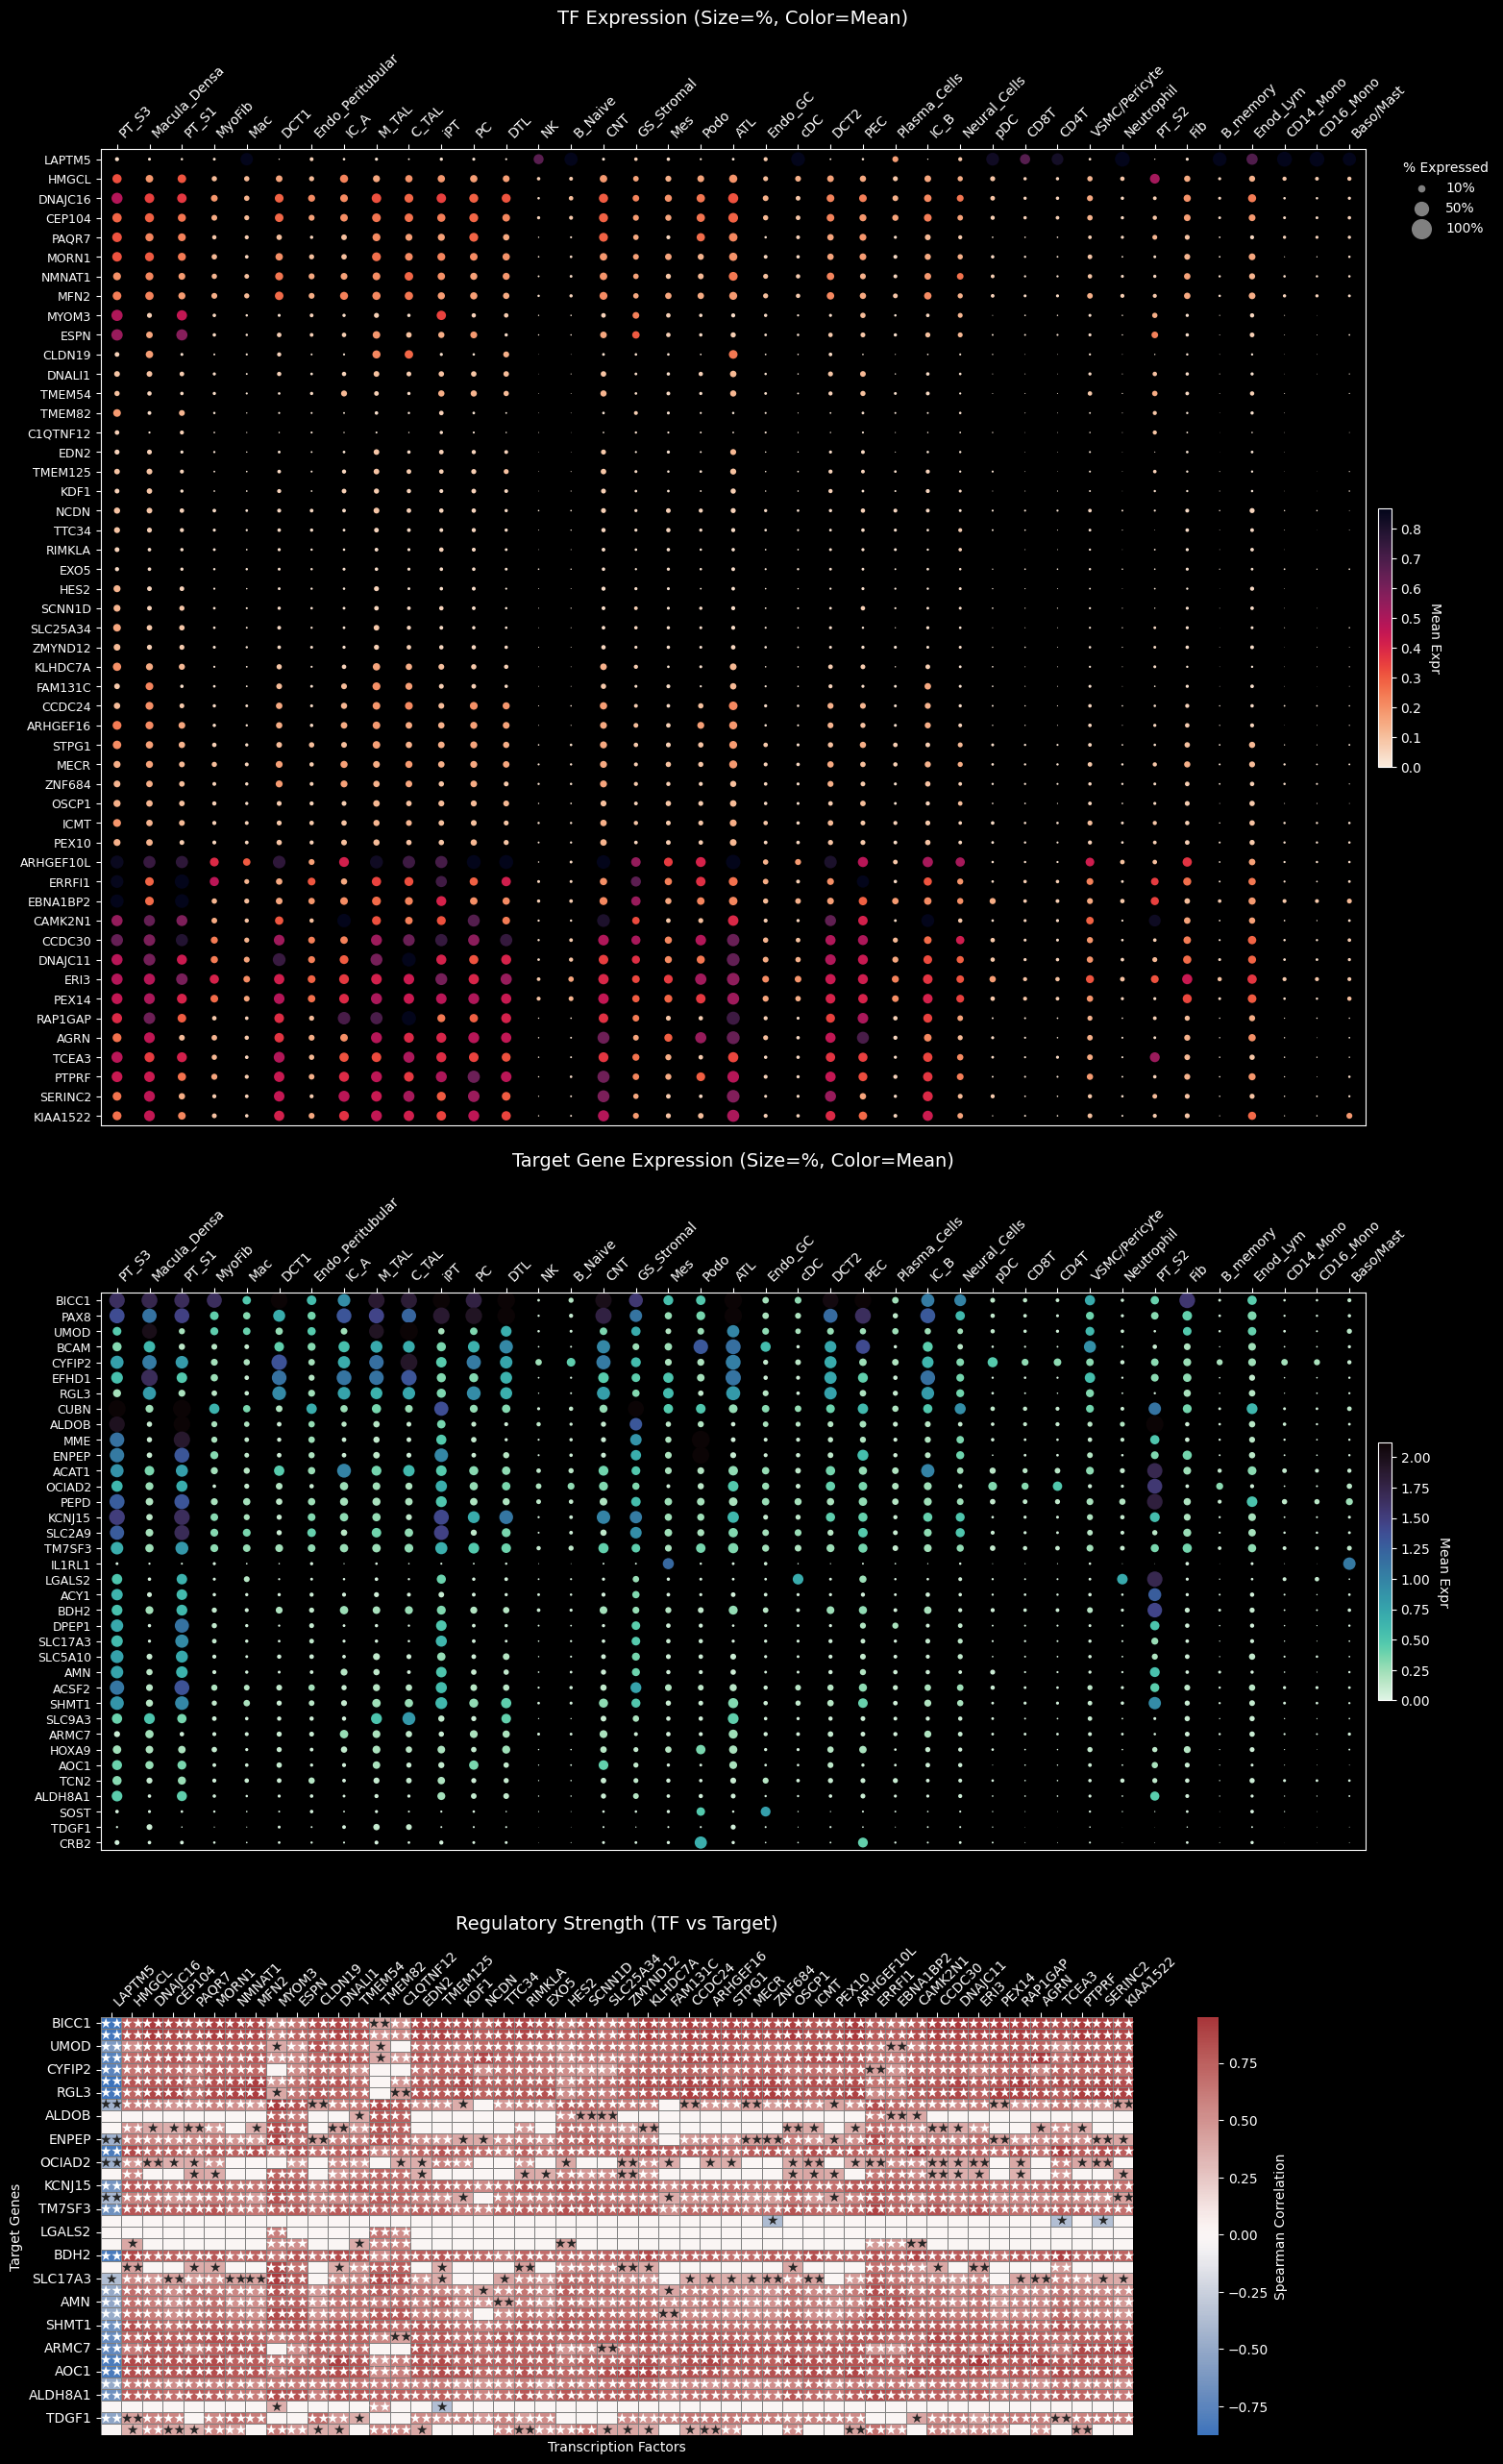

In [8]:
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import os

# ==========================================
# User settings
# ==========================================
outdir = "/mnt/home3/miska/nm667/scratch/inProgress/dev/figr_cluster_pipeline"
adata_path = "/mnt/home3/miska/nm667/scratch/inProgress/dev/data/Kidney_SC/GSE211785_Susztak_KPMP_SC_SN_ATAC_merged_PostSCVI_final.h5ad"
corr_file = f"{outdir}/tf_gene_significant.csv"
cluster_col = "Cluster_Idents_New2"
TOP_TF = 50

# 1. Deduplicate the list immediately to prevent "Ambiguous Series" error
TARGET_GENES = list(set([
    "AOC1", "DPEP1", "CYFIP2", "TM7SF3", "SLC9A3", "ACAT1", "HOXA9", "LGALS2",
    "CUBN", "SLC2A9", "EFHD1", "IL1RL1", "ALDH8A1", "BICC1", "PEPD", "SLC17A3",
    "ARMC7", "PAX8", "ALDOB", "ENPEP", "OCIAD2", "CRB2", "SLC5A10", "KCNJ15",
    "BDH2", "AMN", "ACSF2", "SOST", "UMOD", "SHMT1", "SHMT1", "TCN2", "BCAM",
    "MME", "AC092653.5", "RGL3", "TDGF1", "ACY1"
]))

os.makedirs(outdir, exist_ok=True)

# ==========================================
# 2. Load data
# ==========================================
print("📂 Loading AnnData and correlation results...")
adata = sc.read_h5ad(adata_path)
corr_df = pd.read_csv(corr_file)

# Select Top TFs
top_tfs = (
    corr_df.groupby("tf")["spearman"]
    .median()
    .abs()
    .sort_values(ascending=False)
    .head(TOP_TF)
    .index.tolist()
)

# Filter for genes actually in the dataset
# Ensure unique lists
valid_tfs = [t for t in top_tfs if t in adata.raw.var_names]
valid_genes = [g for g in TARGET_GENES if g in adata.raw.var_names]

# ==========================================
# 3. Compute Dot Plot Stats (Mean & Percent)
# ==========================================


def get_dotplot_data(adata, features, cluster_col):
    """
    Returns two DataFrames:
    1. Mean expression per cluster
    2. Percent of cells expressing (>0) per cluster
    """
    clusters = adata.obs[cluster_col].unique()
    mean_df = pd.DataFrame(index=clusters, columns=features)
    pct_df = pd.DataFrame(index=clusters, columns=features)

    for cl in clusters:
        cells = adata.obs.index[adata.obs[cluster_col] == cl]
        # Extract raw counts (or normalized if preferred, using raw here)
        sub_X = adata.raw[cells, features].X

        # Convert to dense if sparse
        if hasattr(sub_X, "toarray"):
            sub_X = sub_X.toarray()

        # 1. Mean Expression
        mean_df.loc[cl] = np.mean(sub_X, axis=0)

        # 2. Percent Expressing (> 0)
        # Calculate fraction of cells with counts > 0
        pct_df.loc[cl] = np.mean(sub_X > 0, axis=0)

    return mean_df.astype(float), pct_df.astype(float)


print("Computing stats for Dot Plots...")
tf_mean, tf_pct = get_dotplot_data(adata, valid_tfs, cluster_col)
gene_mean, gene_pct = get_dotplot_data(adata, valid_genes, cluster_col)

# ==========================================
# 4. Clustering & Ordering
# ==========================================
# Normalize means just for clustering (dendrogram calculation)


def quick_cluster_order(df):
    df_log = np.log1p(df)
    cg = sns.clustermap(df_log.T, cmap="viridis", figsize=(1, 1))
    order = cg.dendrogram_row.reordered_ind
    plt.close("all")
    return df.columns[order]


ordered_tfs = quick_cluster_order(tf_mean)
ordered_genes = quick_cluster_order(gene_mean)

# Reorder all dataframes
tf_mean = tf_mean[ordered_tfs]
tf_pct = tf_pct[ordered_tfs]
gene_mean = gene_mean[ordered_genes]
gene_pct = gene_pct[ordered_genes]

# ==========================================
# 5. Helper Function: Draw Dot Plot
# ==========================================


def draw_dotplot(ax, mean_df, pct_df, title, cmap="Reds"):
    """
    Custom Dot Plot on a given Matplotlib axis.
    X-axis: Clusters
    Y-axis: Genes/TFs
    """
    # Transpose so Y is Genes, X is Clusters
    mean_data = mean_df.T
    pct_data = pct_df.T

    y_labels = mean_data.index
    x_labels = mean_data.columns

    # Create meshgrid for plotting
    x, y = np.meshgrid(np.arange(len(x_labels)), np.arange(len(y_labels)))

    # Flatten for scatter plot
    x_flat = x.flatten()
    y_flat = y.flatten()
    c_flat = mean_data.values.flatten()  # Color by mean
    s_flat = pct_data.values.flatten() * 100  # Size by percent (scale up)

    # Normalize color
    norm = mcolors.Normalize(vmin=0, vmax=np.percentile(
        c_flat, 99))  # Clip top 1% outliers

    # Plot
    scatter = ax.scatter(
        x_flat, y_flat,
        s=s_flat * 2,  # Scale factor for dot size
        c=c_flat,
        cmap=cmap,
        norm=norm,
        edgecolors='none'
    )

    # Formatting
    ax.set_xticks(np.arange(len(x_labels)))
    ax.set_xticklabels(x_labels, rotation=45, ha="left", fontsize=10)
    ax.xaxis.tick_top()  # Put labels on top like heatmap

    ax.set_yticks(np.arange(len(y_labels)))
    ax.set_yticklabels(y_labels, fontsize=9)

    ax.set_title(title, pad=20, fontsize=14)

    # Add borders manually similar to heatmap grid
    ax.set_xlim(-0.5, len(x_labels)-0.5)
    ax.set_ylim(-0.5, len(y_labels)-0.5)
    ax.invert_yaxis()  # To match heatmap order (top to bottom)

    return scatter


# ==========================================
# 6. Final Visualization
# ==========================================
fig, axes = plt.subplots(
    3, 1,
    figsize=(16, 26),
    height_ratios=[3.5, 2.0, 1.5]  # Adjust based on number of TFs vs Genes
)

# --- Panel 1: TF Dot Plot ---
# Size = % Expressing, Color = Mean Expression
sc1 = draw_dotplot(axes[0], tf_mean, tf_pct,
                   "TF Expression (Size=%, Color=Mean)", cmap="rocket_r")
# Colorbar for TF
cbar1 = plt.colorbar(sc1, ax=axes[0], fraction=0.01, pad=0.01)
cbar1.set_label("Mean Expr", rotation=270, labelpad=15)

# --- Panel 2: Target Gene Dot Plot ---
sc2 = draw_dotplot(axes[1], gene_mean, gene_pct,
                   "Target Gene Expression (Size=%, Color=Mean)", cmap="mako_r")
# Colorbar for Genes
cbar2 = plt.colorbar(sc2, ax=axes[1], fraction=0.01, pad=0.01)
cbar2.set_label("Mean Expr", rotation=270, labelpad=15)

# --- Panel 3: Correlation Heatmap ---
# Prepare Matrix
corr_mat = corr_df.pivot_table(index="gene", columns="tf", values="spearman").reindex(
    index=ordered_genes, columns=ordered_tfs).fillna(0)
pval_mat = corr_df.pivot_table(index="gene", columns="tf", values="pval").reindex(
    index=ordered_genes, columns=ordered_tfs)

# Annotations (Stars)
sig_mask = pval_mat.copy().astype(str)
sig_mask[:] = ""
for g in ordered_genes:
    for t in ordered_tfs:
        p = pval_mat.loc[g, t]
        if pd.isna(p):
            continue
        if p < 0.01:
            sig_mask.loc[g, t] = "★★"
        elif p < 0.05:
            sig_mask.loc[g, t] = "★"

sns.heatmap(
    corr_mat,
    cmap="vlag",
    center=0,
    annot=sig_mask,
    fmt="",
    ax=axes[2],
    cbar_kws={"label": "Spearman Correlation"},
    linewidths=0.5,
    linecolor='gray'
)
axes[2].set_title("Regulatory Strength (TF vs Target)", fontsize=14, pad=10)
axes[2].set_xlabel("Transcription Factors")
axes[2].set_ylabel("Target Genes")
axes[2].xaxis.tick_top()
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45, ha="left")

# Add a legend for Dot Size
# We create a dummy axis to hold the size legend
legend_elements = [
    plt.scatter([], [], s=10*2, c='gray', label='10%'),
    plt.scatter([], [], s=50*2, c='gray', label='50%'),
    plt.scatter([], [], s=100*2, c='gray', label='100%')
]
axes[0].legend(
    handles=legend_elements,
    title="% Expressed",
    bbox_to_anchor=(1.02, 1),
    loc="upper left",
    frameon=False
)

plt.tight_layout(pad=2.0)
plt.savefig(f"{outdir}/TF_Gene_Dotplots_Corr.png",
            dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
adata.var["name-2"].head()


A1BG        A1BG
A1BG-AS1     nan
A1CF        A1CF
A2M          A2M
A2M-AS1      nan
Name: name-2, dtype: category
Categories (18965, object): ['A1BG', 'A1CF', 'A2M', 'A2ML1', ..., 'ZYG11B', 'ZYX', 'ZZEF1', 'nan']